Датасет: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

Что помогло:
* one-hot encoding для room_type
* one-hot encoding для neighbourhood_group
* label encoding для neighbourhood
* добавление параметров, указывающих расстояние до каждой группы районов
* заполнение пропусков для параметра reviews_per_month 0
* удаление строк со слишком большим или слишком маленьким значением price
* использование стандартизации и нормализации, более продвинутых моделей, таких как Random Forest и CatBoost
* использование усредненной суммы результатов Random Forest и CatBoost 

Что не помогло:
* перевод last-review из формата год-месяц-день в цифру, обозначающую кол-во дней
* логарифмирование параметров, распределение которых хоть как-то напоминает нормальное
* ручное изменение параметров CatBoost не дало улучшений, автоматический подгон по этой причине не проводился

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/hw_5_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [4]:
df = pd.read_csv('/content/data/AB_NYC_2019.csv')

In [5]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [7]:
df.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [8]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [9]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

In [10]:
df['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [11]:
len(df['neighbourhood'].unique())

221

In [12]:
len(df['neighbourhood'].unique()) / len(df['neighbourhood'])

0.004519889559259638

In [13]:
df['Brooklyn_dist'] = 0
df['Manhattan_dist'] = 0
df['Queens_dist'] = 0
df['Staten_Island_dist'] = 0
df['Bronx_dist'] = 0

In [14]:
from datetime import datetime

districts = {
    'Brooklyn': {'x': 40.649659, 'y': -73.956923},
    'Manhattan': {'x': 40.7834, 'y': -73.9662},
    'Queens': {'x': 40.66, 'y': -73.839},
    'Staten_Island': {'x': 40.56233, 'y': -74.13986},
    'Bronx': {'x': 40.8498, 'y': -73.8664},
}

def date_to_days(value):
    if type(value) == float:
        return 734000
    year, month, day = map(int, value.split('-'))
    return (datetime(year, month, day) - datetime(1, 1, 1)).days

def distance(x, y, district):
    coord = districts[district]
    return ((x - coord['x']) ** 2 + (y - coord['y']) ** 2) ** 0.5

neighbourhood_values = df['neighbourhood'].value_counts()

df = df.join(pd.get_dummies(df['neighbourhood_group'])).drop('neighbourhood_group', axis=1)
df = df.join(pd.get_dummies(df['room_type'])).drop('room_type', axis=1)
df['neighbourhood'] = [neighbourhood_values[value] for value in df['neighbourhood']]
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
# df['last_review'] = [date_to_days(value) for value in df['last_review']]
df['Brooklyn_dist'] = [distance(x, y, 'Brooklyn') for (x, y) in zip(df['latitude'], df['longitude'])]
df['Manhattan_dist'] = [distance(x, y, 'Manhattan') for (x, y) in zip(df['latitude'], df['longitude'])]
df['Queens_dist'] = [distance(x, y, 'Queens') for (x, y) in zip(df['latitude'], df['longitude'])]
df['Staten_Island_dist'] = [distance(x, y, 'Staten_Island') for (x, y) in zip(df['latitude'], df['longitude'])]
df['Bronx_dist'] = [distance(x, y, 'Bronx') for (x, y) in zip(df['latitude'], df['longitude'])]

In [15]:
corr = df.corr()

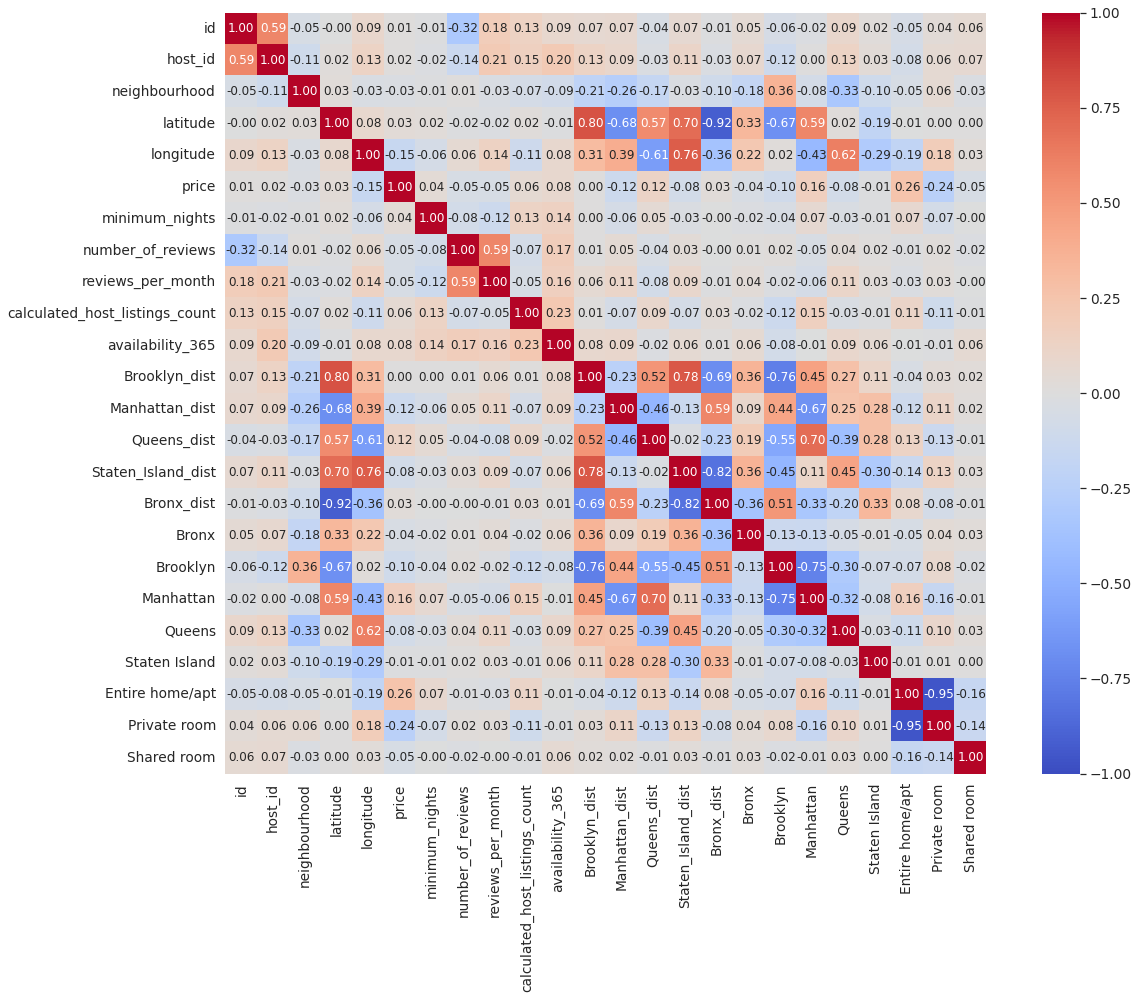

In [16]:
valid_indexes = df.columns
valid_corr = df[valid_indexes].corr()
valid_indexes = valid_corr.columns

plt.figure(figsize=(20, 14))
sns.set(font_scale=1.25)
sns.heatmap(valid_corr, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=valid_indexes, xticklabels=valid_indexes, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

In [17]:
df = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)

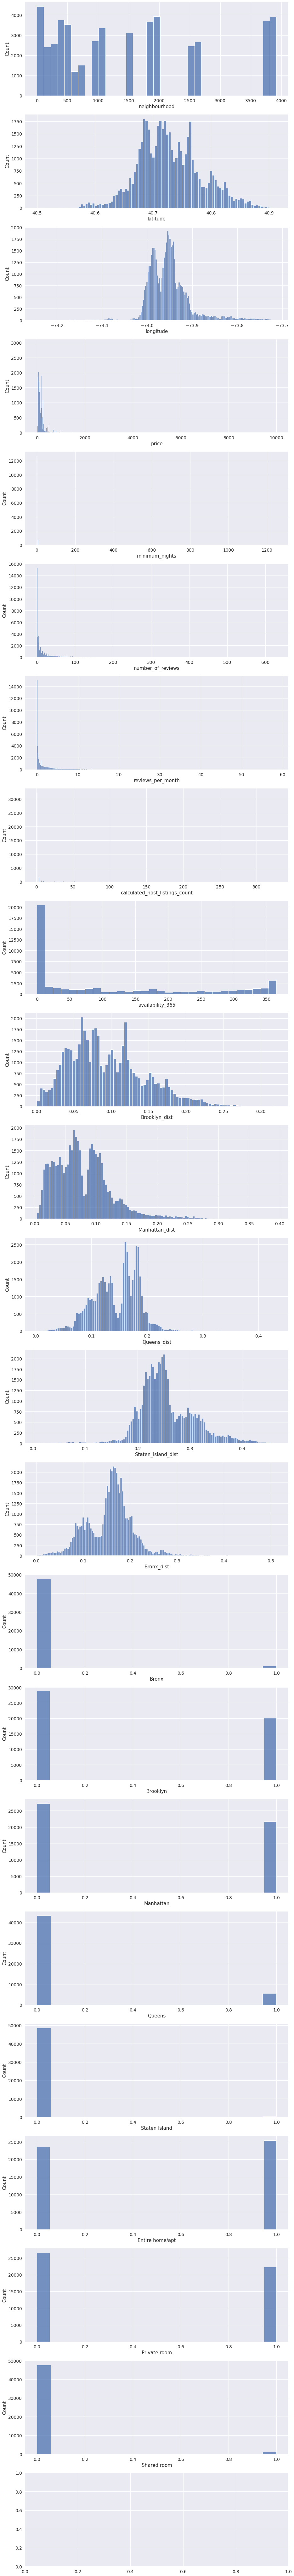

In [18]:
fig, axs = plt.subplots(nrows=23)
fig.set_figheight(150)
fig.set_figwidth(15)

k = 0
for param in df.columns:
    sns.histplot(df, x=param, ax=axs[k])
    k += 1

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

def show_metrics(y_test, y_pred, name=''):
    return f'''
{name}
R2: {r2_score(y_test, y_pred)}
MAE: {mean_absolute_error(y_test, y_pred)}
RMSE: {mean_squared_error(y_test, y_pred, squared=False)}
Total: {len(y_test)}
'''

In [20]:
X = df.drop(['price', 'neighbourhood', 'reviews_per_month', 'latitude', 'longitude', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx', 'Brooklyn_dist', 'Manhattan_dist', 'Queens_dist', 'Staten_Island_dist', 'Bronx_dist', 'Entire home/apt', 'Private room', 'Shared room'], axis=1)
Y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [21]:
linr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rc = Ridge()
ls = Lasso()
en = ElasticNet()
lr = LogisticRegression(n_jobs=-1)
rf = RandomForestRegressor(n_jobs=-1)
regressor = CatBoostRegressor(random_state=42, verbose=False)

linr.fit(X_train, y_train)
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
rc.fit(X_train, y_train)
ls.fit(X_train, y_train)
en.fit(X_train, y_train)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
regressor.fit(X_train, y_train)

y_pred_linr = linr.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rc = rc.predict(X_test)
y_pred_ls = ls.predict(X_test)
y_pred_en = en.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_catboost = regressor.predict(X_test)

In [22]:
print(show_metrics(y_test, y_pred_linr, name='Linear Regression Default'))
print(show_metrics(y_test, y_pred_rc, name='Ridge Default'))
print(show_metrics(y_test, y_pred_ls, name='Lasso Default'))
print(show_metrics(y_test, y_pred_en, name='ElasticNet Default'))
print(show_metrics(y_test, y_pred_knn, name='KNN Default'))
print(show_metrics(y_test, y_pred_dt, name='Decition Tree Default'))
print(show_metrics(y_test, y_pred_lr, name='Logistic Regression Default'))
print(show_metrics(y_test, y_pred_rf, name='Random Forest Default'))
print(show_metrics(y_test, y_pred_catboost, name='CatBoost Default'))


Linear Regression Default
R2: 0.014608480271463442
MAE: 88.76709365678299
RMSE: 199.49263276388507
Total: 14669


Ridge Default
R2: 0.014608480331965157
MAE: 88.76709363877708
RMSE: 199.4926327577608
Total: 14669


Lasso Default
R2: 0.014615529841077723
MAE: 88.76518266152682
RMSE: 199.49191916949678
Total: 14669


ElasticNet Default
R2: 0.01461304541319719
MAE: 88.76582431327823
RMSE: 199.49217065660082
Total: 14669


KNN Default
R2: -0.1811658150687654
MAE: 95.53215624786965
RMSE: 218.41269934613933
Total: 14669


Decition Tree Default
R2: -1.0836652777098839
MAE: 105.53133180213649
RMSE: 290.0924520665976
Total: 14669


Logistic Regression Default
R2: -0.04353291210507915
MAE: 85.12393482855
RMSE: 205.29365511860942
Total: 14669


Random Forest Default
R2: -0.12255180890607709
MAE: 91.10798275912252
RMSE: 212.92450618086067
Total: 14669


CatBoost Default
R2: -0.07335488958197955
MAE: 85.14585782958777
RMSE: 208.20642212234736
Total: 14669



In [23]:
q_97 = df['price'].quantile(0.97)
df = df[(df.price < q_97) & (df.price > 20)]
X = df.drop('price', axis=1)
Y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Если хочется убрать выбросы только в X_train и y_train

In [24]:
# q_97 = df['price'].quantile(0.97)
# X_train.index = [i for i in range(len(X_train))]
# y_train = y_train.tolist()
# for price in y_train:
#     if price >= q_97 or price < 20:
#         index = 1
#         while index != -1:
#             try:
#                 index = y_train.index(price)
#                 del y_train[index]
#                 X_train.drop(X_train.index[index], inplace=True)
#             except:
#                 index = -1

In [25]:
X_train_copy = X_train.copy()
X_train_copy['price'] = y_train
X_train_copy.describe()

,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Brooklyn_dist,Manhattan_dist,...,Bronx_dist,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,price
count,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,...,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000,33048.000000
mean,1520.690753,40.729014,-73.951265,6.970891,23.588568,1.102820,6.977518,110.027959,0.094390,0.079112,...,0.156852,0.023542,0.416122,0.433642,0.118827,0.007867,0.507625,0.469106,0.023269,127.390008
std,1265.384596,0.055234,0.046359,20.291464,45.201662,1.632359,32.348162,130.286294,0.051182,0.046066,...,0.048875,0.151618,0.492922,0.495585,0.323590,0.088350,0.499949,0.499052,0.150759,79.855953
min,1.000000,40.499790,-74.244420,1.000000,0.000000,0.000000,1.000000,0.000000,0.000967,0.004039,...,0.001890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,392.000000,40.689930,-73.982420,1.000000,1.000000,0.050000,1.000000,0.000000,0.056845,0.044542,...,0.122551,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,68.000000
50%,1117.000000,40.722405,-73.954820,3.000000,5.000000,0.380000,1.000000,42.000000,0.083773,0.071906,...,0.162388,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,100.000000
75%,2465.000000,40.763350,-73.935088,5.000000,24.000000,1.610000,2.000000,217.000000,0.124633,0.104103,...,0.183558,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,168.250000
max,3920.000000,40.912340,-73.717950,1250.000000,629.000000,58.500000,327.000000,365.000000,0.321045,0.394793,...,0.512555,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,449.000000


In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler, normalize
scaler = RobustScaler()

X_train = normalize(scaler.fit_transform(X_train))
X_test = normalize(scaler.transform(X_test))

In [27]:
linr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()
rc = Ridge()
ls = Lasso()
en = ElasticNet()
lr = LogisticRegression(n_jobs=-1)
rf = RandomForestRegressor(n_jobs=-1)
regressor = CatBoostRegressor(random_state=42, iterations=1500, verbose=False)

linr.fit(X_train, y_train)
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)
rc.fit(X_train, y_train)
ls.fit(X_train, y_train)
en.fit(X_train, y_train)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
regressor.fit(X_train, y_train)

y_pred_linr = linr.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)
y_pred_rc = rc.predict(X_test)
y_pred_ls = ls.predict(X_test)
y_pred_en = en.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_catboost = regressor.predict(X_test)

In [28]:
y_pred_cb_rf = []
for (x, y) in zip(y_pred_rf, y_pred_catboost):
    y_pred_cb_rf.append((x + y) / 2)

In [29]:
print(show_metrics(y_test, y_pred_linr, name='Linear Regression'))
print(show_metrics(y_test, y_pred_rc, name='Ridge'))
print(show_metrics(y_test, y_pred_ls, name='Lasso'))
print(show_metrics(y_test, y_pred_en, name='ElasticNet'))
print(show_metrics(y_test, y_pred_lr, name='Logistic Regression'))
print(show_metrics(y_test, y_pred_knn, name='KNN'))
print(show_metrics(y_test, y_pred_dt, name='Decition Tree'))
print(show_metrics(y_test, y_pred_rf, name='Random Forest'))
print(show_metrics(y_test, y_pred_catboost, name='CatBoost'))
print(show_metrics(y_test, y_pred_cb_rf, name='CatBoost + Random Forest'))


Linear Regression
R2: 0.39728226375043896
MAE: 44.62970350567514
RMSE: 62.24495229625167
Total: 14164


Ridge
R2: 0.3966256885713707
MAE: 44.67516350370432
RMSE: 62.2788465756134
Total: 14164


Lasso
R2: 0.3396689157151216
MAE: 47.193304684107744
RMSE: 65.15204071893419
Total: 14164


ElasticNet
R2: 0.08289344244391916
MAE: 59.16482217706118
RMSE: 76.7815812834411
Total: 14164


Logistic Regression
R2: 0.3421987772431673
MAE: 43.23220841570178
RMSE: 65.02711564844793
Total: 14164


KNN
R2: 0.4595542535728373
MAE: 40.250607173114936
RMSE: 58.94177416877804
Total: 14164


Decition Tree
R2: 0.11038529316241985
MAE: 50.497458345100256
RMSE: 75.62199485348083
Total: 14164


Random Forest
R2: 0.5304191777833105
MAE: 37.53093558787536
RMSE: 54.94172977583942
Total: 14164


CatBoost
R2: 0.5433277097620054
MAE: 37.08865701812154
RMSE: 54.181307704298554
Total: 14164


CatBoost + Random Forest
R2: 0.5475694287239095
MAE: 36.83874970967529
RMSE: 53.929093980181456
Total: 14164



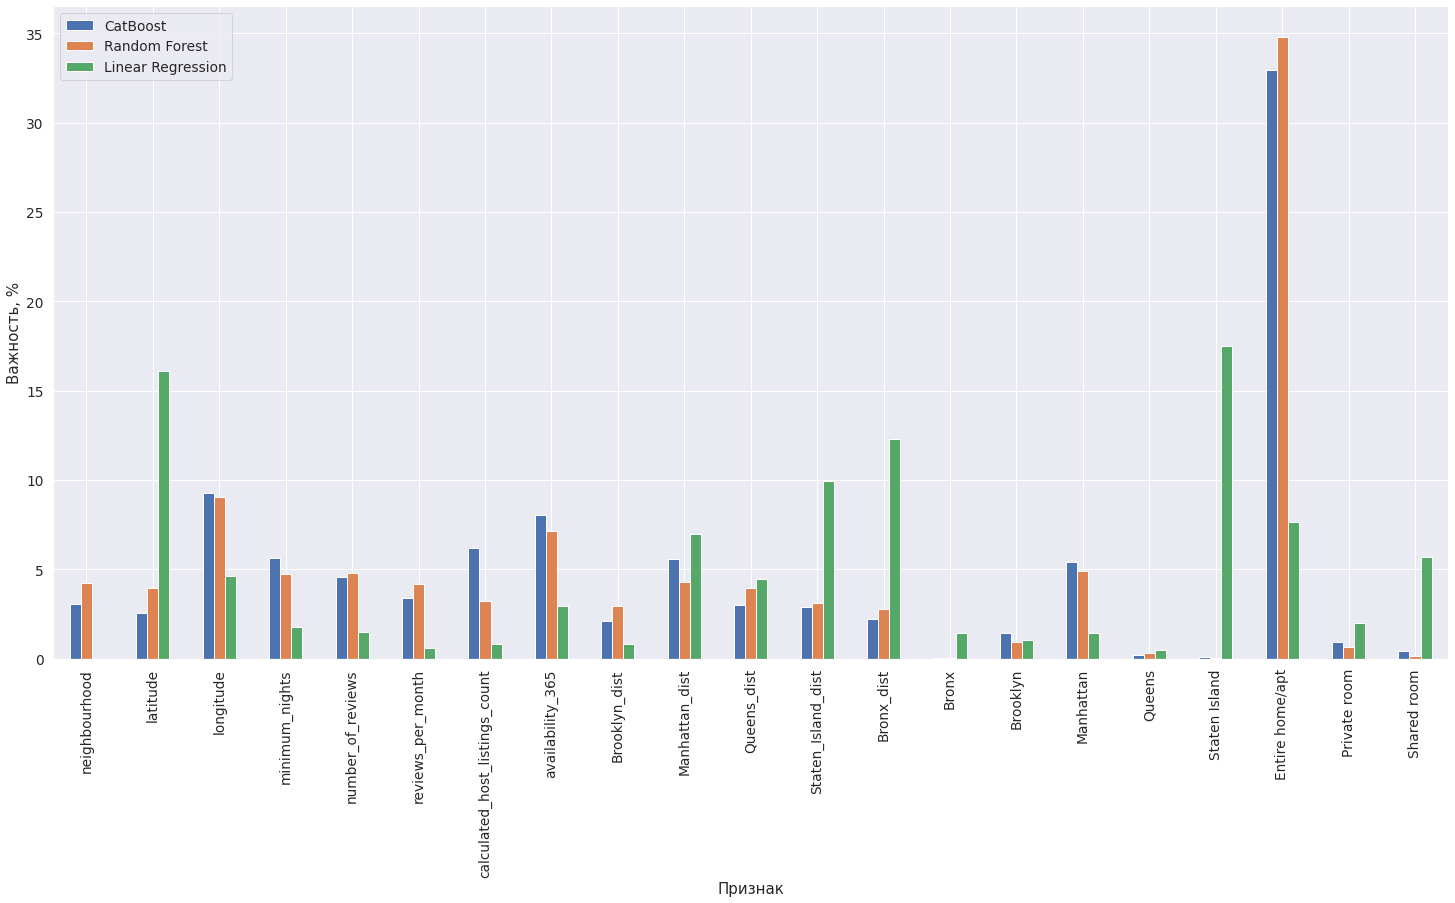

In [30]:
linr_weights = np.abs(linr.coef_)
fe_df = pd.DataFrame(
    {
        'CatBoost' : regressor.get_feature_importance(),
        'Random Forest': list(map(lambda x: x * 100, rf.feature_importances_)),
        'Linear Regression': list(map(lambda x: x / sum(linr_weights) * 100, linr_weights)),
    },
    index=df.drop('price', axis=1).columns
)

fig, ax = plt.subplots(figsize=(25, 12))
ax = fe_df.plot.bar(ax=ax)
ax.set_xlabel('Признак')
ax.set_ylabel('Важность, %')
plt.show()

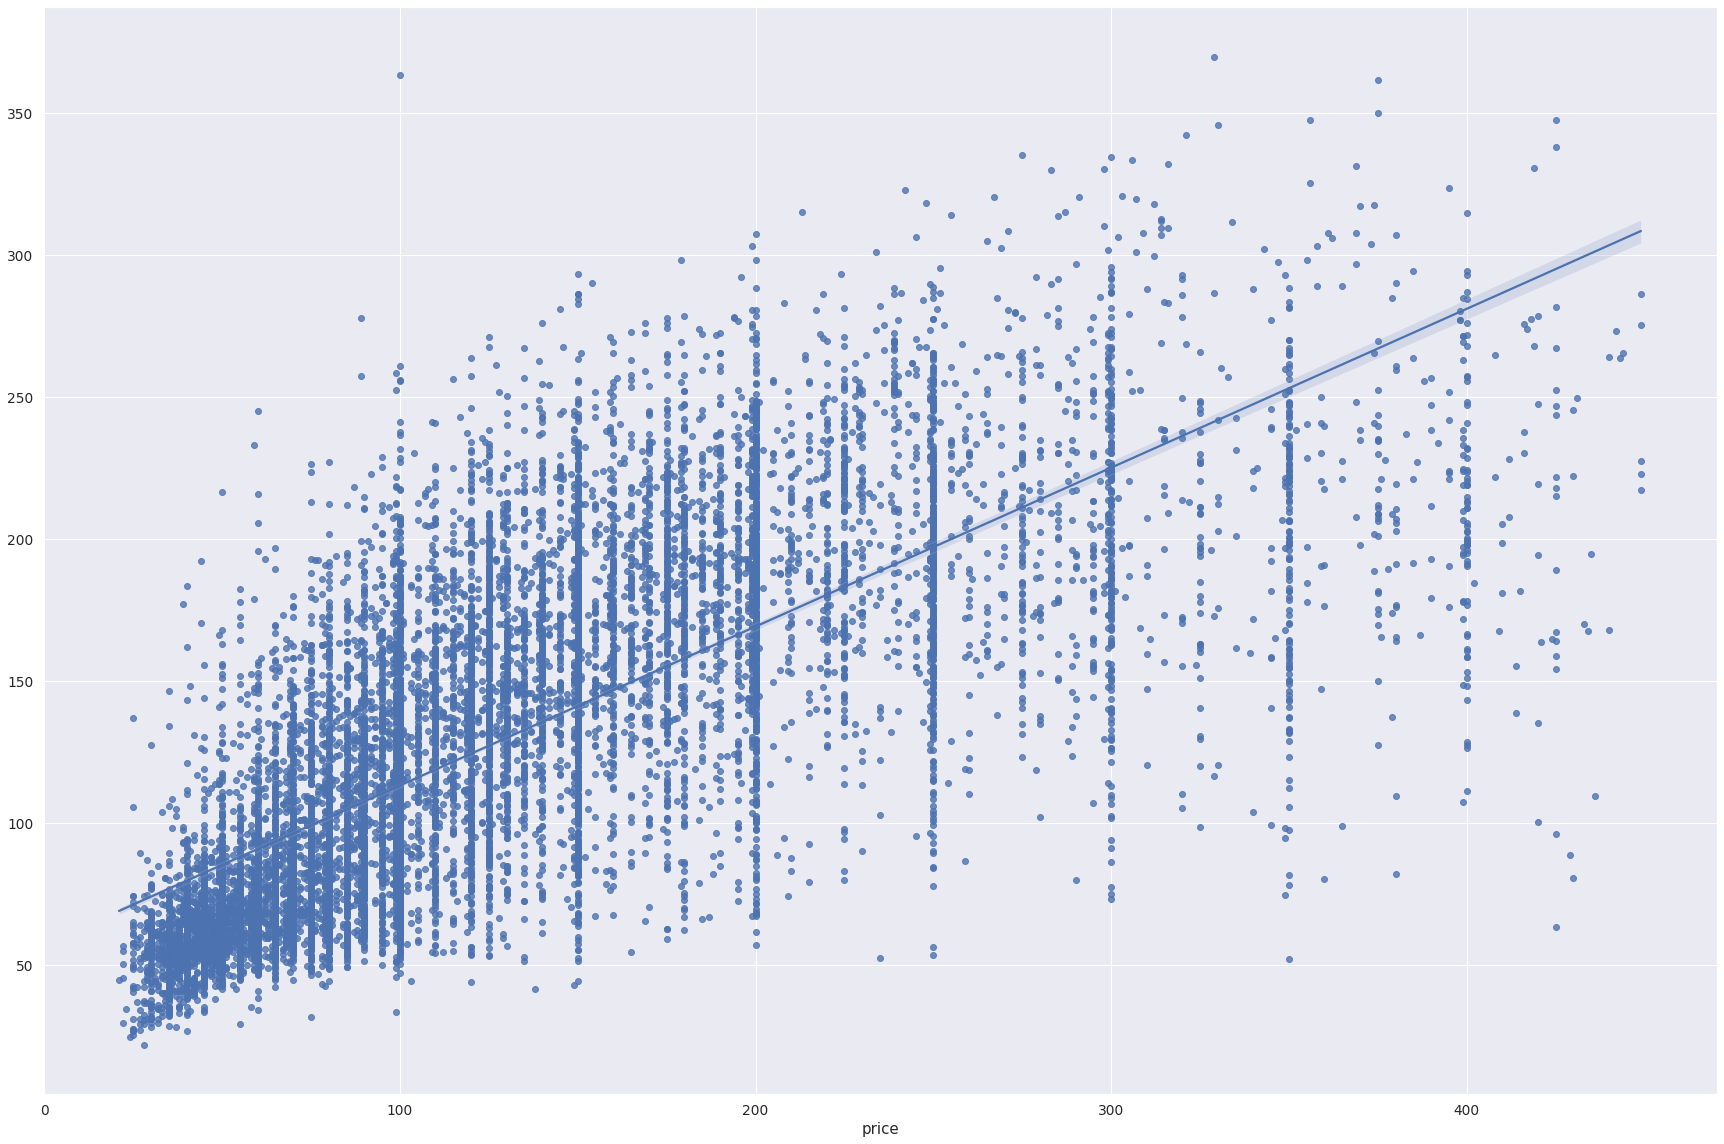

In [31]:
fig, axs = plt.subplots(nrows=1)
fig.set_figheight(20)
fig.set_figwidth(30)

sns.regplot(x=y_test, y=y_pred_cb_rf, ax=axs);

Видно, что модели случайного леса и градиентного бустинга справились лучше регрессионных моделей, поскольку цены на посуточную аренду жилья зависят не только от объективных факторов, но также и от человеческих факторов, которые очень сложно предугадать. К тому же модель линейной регрессии, у которой результат MAE на 3 месте, обращает внимание далеко не на все признаки. Разброс цен хорошо видно на графике выше

Видно, что параметр, отвечающий за то, является ли сдаваемое жилье целым домом, очень сильно влияет на CatBoost и Random Forest